# TDT17 Mini Project
### Road Crack Detection

The goal of this notebook is to help the road authorities in Trønderlag, Norway by detecting cracks in the road
on provided images. The goal is to create a model that can detect cracks in the road, making it easier for the
authorities to find and repair them. We will use the mean average precision (mAP) as a metric to evaluate the
performance of our model.

#### Importing libraries

In [86]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import lxml.etree as ET
import random

#### Setting up data paths

In [87]:
train_path = "./Norway/train/"
test_path = "./Norway/test/"
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
train_annotations_path = os.path.join(train_path, "annotations/xmls")

#### Fetching data from file
This will read the XML in the annotations folder and create a dictionary with the data valuable for the model. The data is transformed into a dictionary with the following format:
```python
{'image': {
    'path': './Norway/train/images/Norway_000005.jpg',
    'width': 3650, 
    'height': 2044}, 
'boxes': [
    {'type': 1, 'coords': (1140.27, 1164.62, 1280.35, 1199.79)}, 
    {'type': 1, 'coords': (155.59, 1601.83, 777.02, 2034.32)}, 
    {'type': 4, 'coords': (1190.21, 1354.48, 1290.52, 1406.12)}, 
    {'type': 4, 'coords': (1286.54, 1427.97, 1376.92, 1455.78)}, 
    {'type': 4, 'coords': (1472.27, 1202.5, 1550.7, 1232.32)}
}
```


In [88]:
def elem2dict(node, attributes=True):
    """
    Convert an lxml.etree node tree into a dict.
    """
    result = {}
    if attributes:
        for item in node.attrib.items():
            key, result[key] = item

    for element in node.iterchildren():
        # Remove namespace prefix
        key = element.tag.split('}')[1] if '}' in element.tag else element.tag

        # Process element as tree element if the inner XML contains non-whitespace content
        if element.text and element.text.strip():
            value = element.text
        else:
            value = elem2dict(element)
        if key in result:
            if type(result[key]) is list:
                result[key].append(value)
            else:
                result[key] = [result[key], value]
        else:
            result[key] = value
    return result


# Converting from xml to dictionary
train_xml = [ET.parse(os.path.join(train_annotations_path, x)).getroot()
             for x in os.listdir(train_annotations_path)]
train_dicts = [elem2dict(x) for x in train_xml]

# Converting from dictionary to valid data format


def dict2data(dict):
    holetypes = {"D00": 1, "D10": 2, "D20": 3, "D40": 4}
    image = {"path": os.path.join(train_images_path, dict["filename"]), "width": int(
        dict["size"]["width"]), "height": int(dict["size"]["height"])}
    boxes = []
    if "object" in dict:
        if not type(dict["object"]) is list:
            dict["object"] = [dict["object"]]
        for object in dict["object"]:
            box = {}
            box["type"] = holetypes[object["name"]]
            box["coords"] = [float(object["bndbox"]["xmin"]),
                              float(object["bndbox"]["ymin"]),
                              float(object["bndbox"]["xmax"]),
                              float(object["bndbox"]["ymax"])]
            boxes.append(box)
    else:
        boxes = []
    return {"image": image, "boxes": boxes}


train_data_dict = [dict2data(x) for x in train_dicts]

#### Visualizing some data to check if it is correct

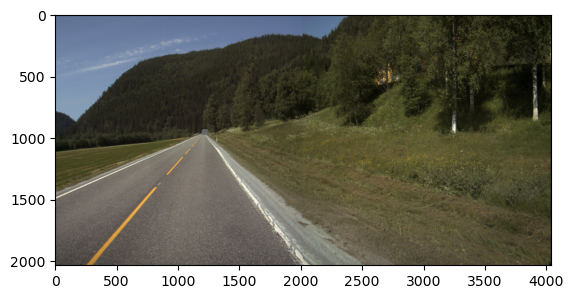

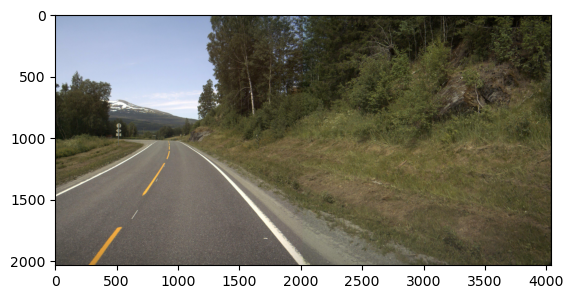

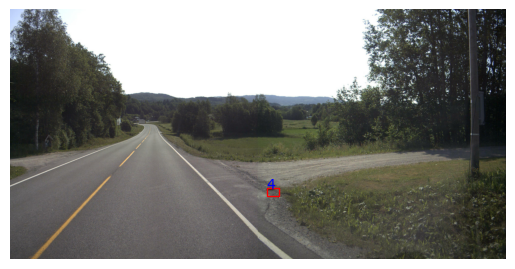

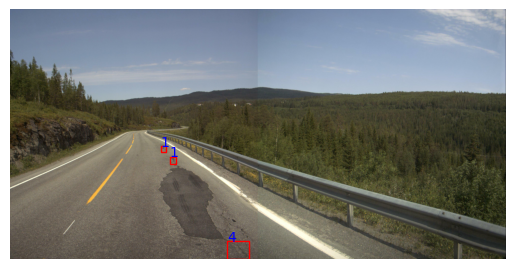

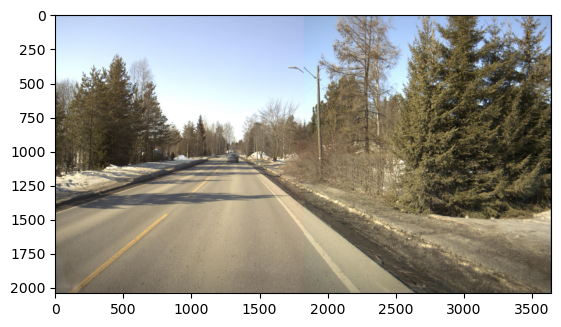

In [89]:
samples = []
while len(samples) < 5:
    data = random.choice(train_data_dict)
    if data["boxes"] is not None:
        samples.append(data)

for data in samples:
    image = Image.open(data["image"]["path"])
    boxes = data["boxes"]
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        xmin, ymin, xmax, ymax = box["coords"]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                             ymax - ymin, fill=False, color="red")
        ax.add_patch(rect)
        plt.text(xmin, ymin, box["type"], color="blue")
        plt.axis("off")
    plt.show()

    

#### Creating a dataset class

In [90]:
class NorwayDataset(torch.utils.data.Dataset):
    def __init__(self, data, image_size=None, transform=None):
        self.data = data
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        image = Image.open(data["image"]["path"])
        boxes = data["boxes"]
        if len(boxes) > 0:
            if len(boxes) > 5:
                random.shuffle(boxes)
                target = np.array([np.array([box["type"]] + box["coords"]) for box in boxes[:5]])
            else: 
                target = np.array([np.array([box["type"]] + box["coords"]) for box in boxes])
                target = np.concatenate((target, np.zeros((5 - len(boxes), 5))))
        else:
            target = np.zeros((5, 5))
        if self.transform is not None:
            image = self.transform(image)
            image_height_scale = self.image_size[0] / \
                data["image"]["height"]
            image_width_scale = self.image_size[1] / data["image"]["width"]
            target[:, 1] *= image_width_scale
            target[:, 2] *= image_height_scale
            target[:, 3] *= image_width_scale
            target[:, 4] *= image_height_scale
        return image, target

#### Creating transform for data

In [91]:
import torchvision.transforms as transforms
image_height = 285
image_width = 400

transform = transforms.Compose([
            transforms.Resize((image_height, image_width)),
            transforms.ToTensor()
        ])

#### Resizing and train test split

In [92]:
test_split_ratio = 0.25

# train test split on 25% (6 to 2)
train_data = train_data_dict[:int(len(train_data_dict) * (1 - test_split_ratio))]
validate_data = train_data_dict[int(len(train_data_dict) * (1 - test_split_ratio)):]

train_fullsize = NorwayDataset(train_data)
train_resized = NorwayDataset(train_data, image_size=(image_height, image_width), transform=transform)
validate_fullsize = NorwayDataset(validate_data)
validate_resized = NorwayDataset(validate_data, image_size=(image_height, image_width), transform=transform)

total_size = len(train_data) + len(validate_data)
train_size = len(train_data)
validate_size = len(validate_data)

print(f"The ratio for the train set is {round(8 * train_size / total_size)}")
print(f"The ratio for the validate set is {round(8 * validate_size / total_size)}")

The ratio for the train set is 6
The ratio for the validate set is 2


#### Upscale function for later when we need to get the correct bounding boxes

In [93]:
def resize_boxes_to_image(boxes, index, type="train"):
    fullsize = train_fullsize if type == "train" else validate_fullsize
    resized = train_resized if type == "train" else validate_resized
    if boxes is not None:
        boxes[:, 1] *= fullsize[index][0].size[0] / resized[index][0].size[0]
        boxes[:, 2] *= fullsize[index][0].size[1] / resized[index][0].size[1]
        boxes[:, 3] *= fullsize[index][0].size[0] / resized[index][0].size[0]
        boxes[:, 4] *= fullsize[index][0].size[1] / resized[index][0].size[1]
    return boxes

#### Creating DataLoaders for training and validation

In [94]:
train_loader = torch.utils.data.DataLoader(train_resized, batch_size=4, shuffle=True, num_workers=0)
validate_loader = torch.utils.data.DataLoader(validate_resized, batch_size=1, shuffle=True, num_workers=0)

#### Creating a pytorch model for training

#### Training the model